In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import time

In [ ]:
U = 1

U_up = U
U_down = -U
U_left = 0
U_right = 0
L = 1
H = 1
Re = 100
nu = U * L / Re
nx = 251
ny = 251
delta_x = L / (nx - 1)
delta_y = H / (ny - 1)
beta =delta_x / delta_y
beta2 = beta ** 2

In [ ]:
sf = np.zeros((nx,ny))
sf0 = np.zeros((nx,ny))
w = np.zeros((nx,ny))
w0 = np.zeros((nx,ny))
u = np.zeros((nx,ny))
v = np.zeros((nx,ny))

In [ ]:
u[0,:] = U_down 
u[-1,:] = U_up 
v[:,0] = U_left
v[:,-1] = U_right

# Iteration algorithm

$\omega = (\frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{ \partial y^2})$

$w_{i,j} = (\frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta y^2})$

$\beta^2 = (\frac{\Delta x}{\Delta y})^2$

$\Delta x^2 \omega_{i,j} = \phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j} + \beta^2 \phi_{i,j+1} - 2\beta^2 \phi_{i,j} + \beta^2 \phi_{i,j-1}$

$\phi_{i,j} = (\phi_{i+1,j} + \phi_{i-1,j} + \beta^2 \phi_{i,j+1} + \beta^2 \phi_{i,j-1} + \Delta x^2 \omega_{i,j}) \times \frac{1}{2 + 2\beta^2}$

In [ ]:
def sf_update(SF, w, delta_x, beta2):
    nx,ny = SF.shape
    sf = SF.copy()
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            sf[i,j] = (sf[i+1,j] + sf[i-1,j] +\
                       beta2 * sf[i,j+1] + beta2 * sf[i,j-1] +\
                       (delta_x ** 2) * w[i,j]) / (2 + 2*beta2)

    return sf

$u \frac{\partial \omega}{\partial x} + v \frac{\partial \omega}{\partial y}= \nu (\frac{\partial ^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2})$

$u = \frac{\phi_{i,j+1} - \phi_{i,j-1}}{2 \Delta x}$

$v = -\frac{\phi_{i+1,j} - \phi_{i-1,j}}{2 \Delta y}$

$A = \frac{1}{\nu} (u \frac{\partial \omega}{\partial x} + v \frac{\partial \omega}{\partial y})$

$A = \frac{\omega_{i+1,j} -2\omega_{i,j} + \omega_{i-1,j}}{\Delta x^2} + \frac{\omega_{i,j+1} -2 \omega_{i,j} + \omega_{i-1,j}}{\Delta y^2}$

$\omega_{i,j} = (\omega_{i+1,j} + \omega_{i-1,j} + \beta^2 \omega_{i,j+1} +\beta^2 \omega_{i,j-1} - \Delta x^2 A) \times \frac{1}{2 + 2\beta^2}$

In [ ]:
def w_update(SF, W, U, V, detla_x, delta_y, nu):
    nx, ny = SF.shape

    sf = SF.copy()
    w = W.copy()
    u = U.copy()
    v = V.copy()

    w[0,:] = -2 * (sf[1,:]+ delta_x * u[0,:]) / (delta_x **2)
    w[-1,:] = -2 * (sf[-2,:]+ delta_x * u[-1,:]) / (delta_x **2)
    w[:,0] = -2 * (sf[:,1] + delta_y * v[:,0]) / (delta_y **2)
    w[:,-1] = -2 * (sf[:,-2] + delta_y * v[:,-1]) / (delta_y **2)

    beta2 = (delta_x / delta_y) **2
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            u[i,j] = (sf[i,j+1] - sf[i,j-1]) / (2 * delta_y)
            v[i,j] = -(sf[i+1,j] - sf[i-1,j]) / (2 * delta_x)

            dwdx = (w[i+1,j] - w[i-1,j])/(2 * delta_x)
            dwdy = (w[i,j+1] - w[i,j-1])/(2 * delta_y)

            A = (u[i,j] * dwdx + v[i,j] + dwdy)/ nu

            w[i,j] = (w[i+1,j] + w[i-1,j] + beta2*w[i,j+1] + beta2 * w[i,j-1] - (delta_x**2) * A)/(2 + 2*beta2)
    return w,u,v

$\omega_{0,y} = -2 \frac{\phi_{1,y} + \Delta x. u_{0,y}}{\Delta x^2}$

$\omega_{-1,y} = -2 \frac{\phi_{-2,y} + \Delta x. u_{-1,y}}{\Delta x^2}$

$\omega_{x,0} = -2 \frac{\phi_{x,1} + \Delta y. v_{x,0}}{\Delta y^2}$

$\omega_{y,-1} = -2 \frac{\phi_{x,-2} + \Delta y. v_{x,-1}}{\Delta y^2}$

In [ ]:
step = 0
Error_target = 1e-02
Error = 1000

sf_residuals = []
w_residuals = []
u_residuals = []
v_residuals = []

sf_imgs = []
w_imgs  = []
v_imgs  = []
u_imgs  = []
V_total = []

startTime = time.time()
while (Error > Error_target):
    sf_new = sf_update(sf, w, delta_x, beta2)

    w_new, u_new, v_new = w_update(sf,w,u,v, delta_x, delta_y, nu)

    error_sf = np.max(np.abs(sf_new - sf))
    error_w = np.max(np.abs(w_new - w))
    error_u = np.max(np.abs(u_new - u))
    error_v = np.max(np.abs(v_new - v))

    Error = max([error_sf, error_w, error_v, error_u])
    print("{} - {:.4e}   {:.4e}  {:.4e}  {:.4e}".format(step, error_sf,error_w,error_u, error_v))

    sf = sf_new
    w = w_new
    u = u_new
    v = v_new

    sf_residuals.append(error_sf)
    w_residuals.append(error_w)
    v_residuals.append(error_v)
    u_residuals.append(error_u)

    sf_imgs.append(sf)
    w_imgs.append(w)
    u_imgs.append(u)
    v_imgs.append(v)
    V_total.append( np.sqrt(u**2 + v**2))
    step += 1
    
print('---------------------------')
print("Run time: {:e}".format(time.time() -startTime))

0 - 0.0000e+00   5.0000e+02  0.0000e+00  0.0000e+00
1 - 9.5238e-04   7.3797e+01  0.0000e+00  0.0000e+00
2 - 9.3025e-04   1.1905e+02  1.1905e-01  1.1905e-01
3 - 9.2397e-04   1.1628e+02  1.1628e-01  1.1628e-01
4 - 8.4669e-04   7.5522e+01  1.1550e-01  1.1550e-01
5 - 7.2342e-04   5.1600e+01  8.8082e-02  1.0584e-01
6 - 6.8215e-04   3.0967e+01  7.7611e-02  8.9736e-02
7 - 5.8101e-04   2.5046e+01  6.9864e-02  8.6291e-02
8 - 5.4014e-04   1.6876e+01  5.7676e-02  7.2151e-02
9 - 5.0088e-04   1.2453e+01  5.0269e-02  5.6979e-02
10 - 4.5300e-04   9.1310e+00  4.0630e-02  4.5582e-02
11 - 4.1767e-04   7.1458e+00  3.4334e-02  3.9650e-02
12 - 4.0125e-04   5.5379e+00  2.8958e-02  3.4540e-02
13 - 3.8192e-04   4.6937e+00  2.5906e-02  3.0733e-02
14 - 3.6250e-04   4.1688e+00  2.2721e-02  2.8084e-02
15 - 3.4402e-04   3.8084e+00  1.9954e-02  2.6041e-02
16 - 3.2940e-04   3.5297e+00  1.8476e-02  2.4365e-02
17 - 3.2141e-04   3.2765e+00  1.7064e-02  2.2898e-02
18 - 3.1262e-04   3.0319e+00  1.5828e-02  2.1559e-02
19 

# Numpy Roll Algorithm

In [ ]:
def sf_update_roll(SF, w, delta_x, beta2):
    nx,ny = SF.shape
    sf = SF.copy()
    sf[1:-1,1:-1] = ((np.roll(sf,1,0) + np.roll(sf,-1,0) +\
                    beta2 * np.roll(sf,1,1) + beta2* np.roll(sf,-1,1) +\
                   (delta_x ** 2) * w) / (2 + 2*beta2))[1:-1,1:-1]

    return sf

In [ ]:
def w_update_roll(SF, W, U, V, detla_x, delta_y, nu):
    nx, ny = SF.shape

    sf = SF.copy()
    w = W.copy()
    u = U.copy()
    v = V.copy()

    w[0,:] = -2 * (sf[1,:]+ delta_x * u[0,:]) / (delta_x **2)
    w[-1,:] = -2 * (sf[-2,:]+ delta_x * u[-1,:]) / (delta_x **2)
    w[:,0] = -2 * (sf[:,1] + delta_y * v[:,0]) / (delta_y **2)
    w[:,-1] = -2 * (sf[:,-2] + delta_y * v[:,-1]) / (delta_y **2)

    beta2 = (delta_x / delta_y) **2

    u[1:-1,1:-1]  = ((np.roll(sf,1,1) - np.roll(sf,-1,1)) / (2 * delta_y))[1:-1,1:-1] 
    v[1:-1,1:-1] = -((np.roll(sf,1,0) - np.roll(sf,-1,0)) / (2 * delta_x))[1:-1,1:-1] 

    dwdx = (np.roll(w,1,0) - np.roll(w,-1,0))/(2 * delta_x)
    dwdy = (np.roll(w,1,1) - np.roll(w,-1,1))/(2 * delta_y)

    A = (u * dwdx + v * dwdy)/ nu

    w[1:-1,1:-1] = ((np.roll(w,1,0) + np.roll(w,-1,0) + beta2*np.roll(w,1,1) + beta2 * np.roll(w,-1,1)- (delta_x**2) * A)/(2 + 2*beta2))[1:-1,1:-1]
    return w,u,v

In [ ]:
step = 0
Error_target = 1e-02
Error = 1000

sf_residuals = []
w_residuals = []
u_residuals = []
v_residuals = []

sf_imgs = []
w_imgs  = []
v_imgs  = []
u_imgs  = []
V_total = []

startTime = time.time()
while (Error > Error_target):
    sf_new = sf_update_roll(sf, w, delta_x, beta2)

    w_new, u_new, v_new = w_update_roll(sf,w,u,v, delta_x, delta_y, nu)

    error_sf = np.max(np.abs(sf_new - sf))
    error_w = np.max(np.abs(w_new - w))
    error_u = np.max(np.abs(u_new - u))
    error_v = np.max(np.abs(v_new - v))

    Error = max([error_sf, error_w, error_v, error_u])
    print("{} - {:.4e}   {:.4e}  {:.4e}  {:.4e}".format(step, error_sf,error_w,error_u, error_v))

    sf = sf_new
    w = w_new
    u = u_new
    v = v_new

    sf_residuals.append(error_sf)
    w_residuals.append(error_w)
    v_residuals.append(error_v)
    u_residuals.append(error_u)

    sf_imgs.append(sf)
    w_imgs.append(w)
    u_imgs.append(u)
    v_imgs.append(v)
    V_total.append( np.sqrt(u**2 + v**2))
    step += 1
    
print('---------------------------')
print("Run time: {:e}".format(time.time() -startTime))

0 - 0.0000e+00   5.0000e+02  0.0000e+00  0.0000e+00
1 - 5.0000e-04   6.2500e+01  0.0000e+00  0.0000e+00
2 - 5.0000e-04   6.2500e+01  6.2500e-02  6.2500e-02
3 - 4.0625e-04   6.2500e+01  6.2500e-02  6.2500e-02
4 - 4.0625e-04   5.0781e+01  4.6875e-02  4.6875e-02
5 - 3.9062e-04   3.9062e+01  3.9135e-02  5.0781e-02
6 - 3.5645e-04   2.9785e+01  3.4540e-02  4.8828e-02
7 - 3.1787e-04   2.2949e+01  2.8447e-02  4.4556e-02
8 - 3.0029e-04   1.8021e+01  2.3993e-02  3.9734e-02
9 - 2.9178e-04   1.4465e+01  2.2213e-02  3.5141e-02
10 - 2.7896e-04   1.1869e+01  2.1345e-02  3.1059e-02
11 - 2.6424e-04   9.9392e+00  1.9360e-02  2.7543e-02
12 - 2.4902e-04   8.4735e+00  1.7744e-02  2.4559e-02
13 - 2.3410e-04   7.3364e+00  1.5992e-02  2.3792e-02
14 - 2.2710e-04   6.4357e+00  1.4524e-02  2.2827e-02
15 - 2.2208e-04   5.7086e+00  1.3702e-02  2.1780e-02
16 - 2.1619e-04   5.1116e+00  1.2878e-02  2.0716e-02
17 - 2.0977e-04   4.6139e+00  1.1980e-02  1.9673e-02
18 - 2.0310e-04   4.1935e+00  1.1227e-02  1.8674e-02
19 

# Torch roll algorithm

In [ ]:
def sf_update_roll_T(SF, w, delta_x, beta2):
    device = T.device("cuda" if T.cuda.is_available() else "cpu")
    nx,ny = SF.shape
    sf = T.tensor(SF,device=device)
    w = T.tensor(w, device=device)
    sf[1:-1,1:-1] = ((T.roll(sf,1,0) + T.roll(sf,-1,0) +\
                    beta2 * T.roll(sf,1,1) + beta2* T.roll(sf,-1,1) +\
                     (delta_x ** 2) * w) / (2 + 2*beta2))[1:-1,1:-1]

    return sf.cpu().detach().numpy()

In [ ]:
def w_update_roll_T(SF, W, U, V, detla_x, delta_y, nu):
    nx, ny = SF.shape
    device = T.device("cuda" if T.cuda.is_available() else "cpu")
    sf = T.tensor(SF, device=device)
    w = T.tensor(W, device=device)
    u = T.tensor(U, device=device)
    v = T.tensor(V, device=device)

    w[0,:] = -2 * (sf[1,:]+ delta_x * u[0,:]) / (delta_x **2)
    w[-1,:] = -2 * (sf[-2,:]+ delta_x * u[-1,:]) / (delta_x **2)
    w[:,0] = -2 * (sf[:,1] + delta_y * v[:,0]) / (delta_y **2)
    w[:,-1] = -2 * (sf[:,-2] + delta_y * v[:,-1]) / (delta_y **2)

    beta2 = (delta_x / delta_y) **2

    u[1:-1,1:-1]  = ((T.roll(sf,1,1) - T.roll(sf,-1,1)) / (2 * delta_y))[1:-1,1:-1] 
    v[1:-1,1:-1] = -((T.roll(sf,1,0) - T.roll(sf,-1,0)) / (2 * delta_x))[1:-1,1:-1] 

    dwdx = (T.roll(w,1,0) - T.roll(w,-1,0))/(2 * delta_x)
    dwdy = (T.roll(w,1,1) - T.roll(w,-1,1))/(2 * delta_y)

    A = (u * dwdx + v * dwdy)/ nu

    w[1:-1,1:-1] = ((T.roll(w,1,0) + T.roll(w,-1,0) + beta2*T.roll(w,1,1) + beta2 * T.roll(w,-1,1)- (delta_x**2) * A)/(2 + 2*beta2))[1:-1,1:-1]
    return w.cpu().detach().numpy(), u.cpu().detach().numpy(), v.cpu().detach().numpy()

In [ ]:
step = 0
Error_target = 1e-02
Error = 1000

frame = 10

sf_residuals = []
w_residuals = []
u_residuals = []
v_residuals = []

sf_imgs = []
w_imgs  = []
v_imgs  = []
u_imgs  = []
V_total = []

startTime = time.time()
while (Error > Error_target):
    sf_new = sf_update_roll_T(sf, w, delta_x, beta2)

    w_new, u_new, v_new = w_update_roll_T(sf,w,u,v, delta_x, delta_y, nu)

    error_sf = np.max(np.abs(sf_new - sf))
    error_w = np.max(np.abs(w_new - w))
    error_u = np.max(np.abs(u_new - u))
    error_v = np.max(np.abs(v_new - v))

    Error = max([error_sf, error_w, error_v, error_u])
    print("{} - {:.4e}   {:.4e}  {:.4e}  {:.4e}".format(step, error_sf,error_w,error_u, error_v))

    sf = sf_new
    w = w_new
    u = u_new
    v = v_new

    sf_residuals.append(error_sf)
    w_residuals.append(error_w)
    v_residuals.append(error_v)
    u_residuals.append(error_u)

    if (step % frame == 0):
        sf_imgs.append(sf)
        w_imgs.append(w)
        u_imgs.append(u)
        v_imgs.append(v)
        V_total.append( np.sqrt(u**2 + v**2))
    step += 1

print('---------------------------')
print("Run time: {:e}".format(time.time() -startTime))

0 - 0.0000e+00   5.0000e+02  0.0000e+00  0.0000e+00
1 - 5.0000e-04   6.2500e+01  0.0000e+00  0.0000e+00
2 - 5.0000e-04   6.2500e+01  6.2500e-02  6.2500e-02
3 - 4.0625e-04   6.2500e+01  6.2500e-02  6.2500e-02
4 - 4.0625e-04   5.0781e+01  4.6875e-02  4.6875e-02
5 - 3.9062e-04   3.9062e+01  3.9135e-02  5.0781e-02
6 - 3.5645e-04   2.9785e+01  3.4540e-02  4.8828e-02
7 - 3.1787e-04   2.2949e+01  2.8447e-02  4.4556e-02
8 - 3.0029e-04   1.8021e+01  2.3993e-02  3.9734e-02
9 - 2.9178e-04   1.4465e+01  2.2213e-02  3.5141e-02
10 - 2.7896e-04   1.1869e+01  2.1345e-02  3.1059e-02
11 - 2.6424e-04   9.9392e+00  1.9360e-02  2.7543e-02
12 - 2.4902e-04   8.4735e+00  1.7744e-02  2.4559e-02
13 - 2.3410e-04   7.3364e+00  1.5992e-02  2.3792e-02
14 - 2.2710e-04   6.4357e+00  1.4524e-02  2.2827e-02
15 - 2.2208e-04   5.7086e+00  1.3702e-02  2.1780e-02
16 - 2.1619e-04   5.1116e+00  1.2878e-02  2.0716e-02
17 - 2.0977e-04   4.6139e+00  1.1980e-02  1.9673e-02
18 - 2.0310e-04   4.1935e+00  1.1227e-02  1.8674e-02
19 

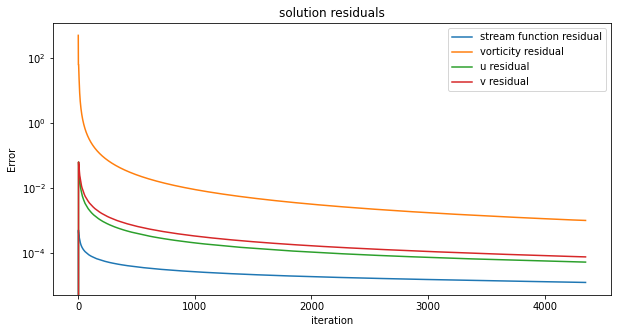

In [ ]:
plt.figure(figsize=(10,5))
plt.yscale('log')
plt.plot(sf_residuals,label='stream function residual')
plt.plot(w_residuals, label='vorticity residual')
plt.plot(u_residuals, label='u residual')
plt.plot(v_residuals, label='v residual')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Error')
_ = plt.title("solution residuals")

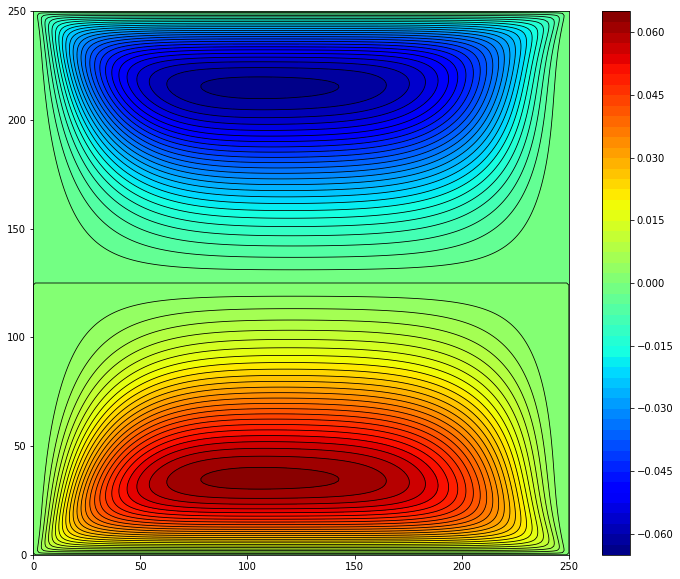

In [ ]:
plt.figure(figsize=(12,10))
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(sf_imgs[-1],50,colors='k',linewidths=0.8)
plt.contourf(sf_imgs[-1],50,cmap='jet')
plt.colorbar()

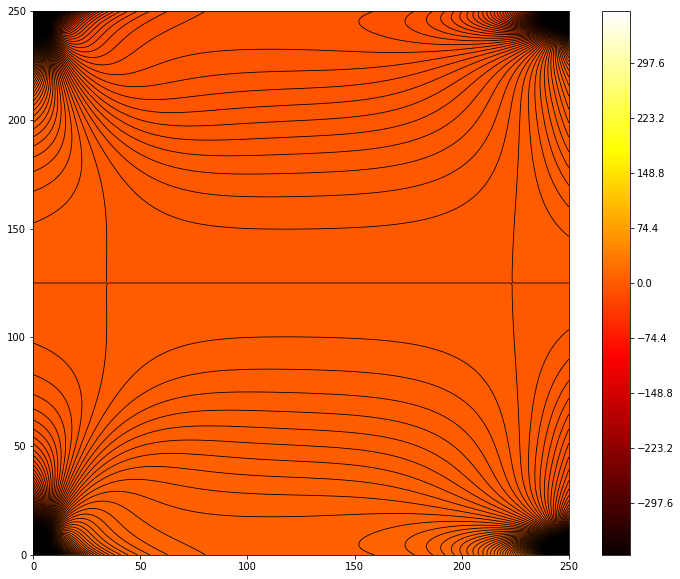

In [ ]:
plt.figure(figsize=(12,10))
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(w_imgs[-1],1000,colors='k',linewidths=0.8)
plt.contourf(w_imgs[-1],1000,cmap='hot')
plt.colorbar()

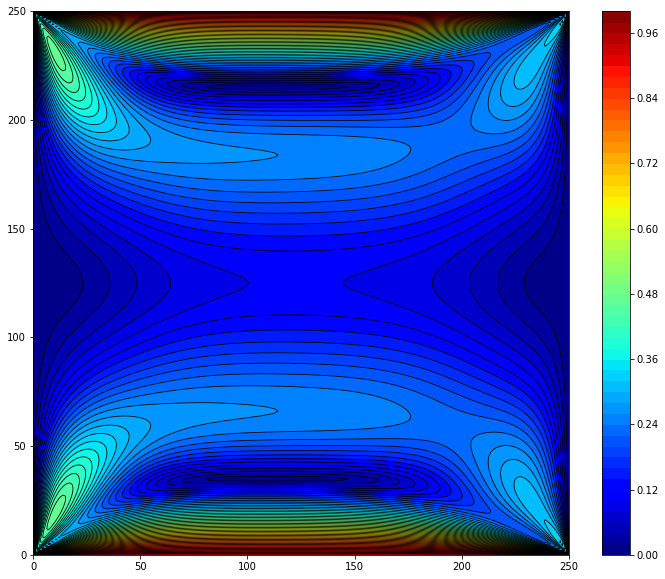

In [ ]:
plt.figure(figsize=(12,10))
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(V_total[-1],50,colors='k',linewidths=0.8)
plt.contourf(V_total[-1],50,cmap='jet')
plt.colorbar()

Text(0.5, 1.0, 'solution residuals')

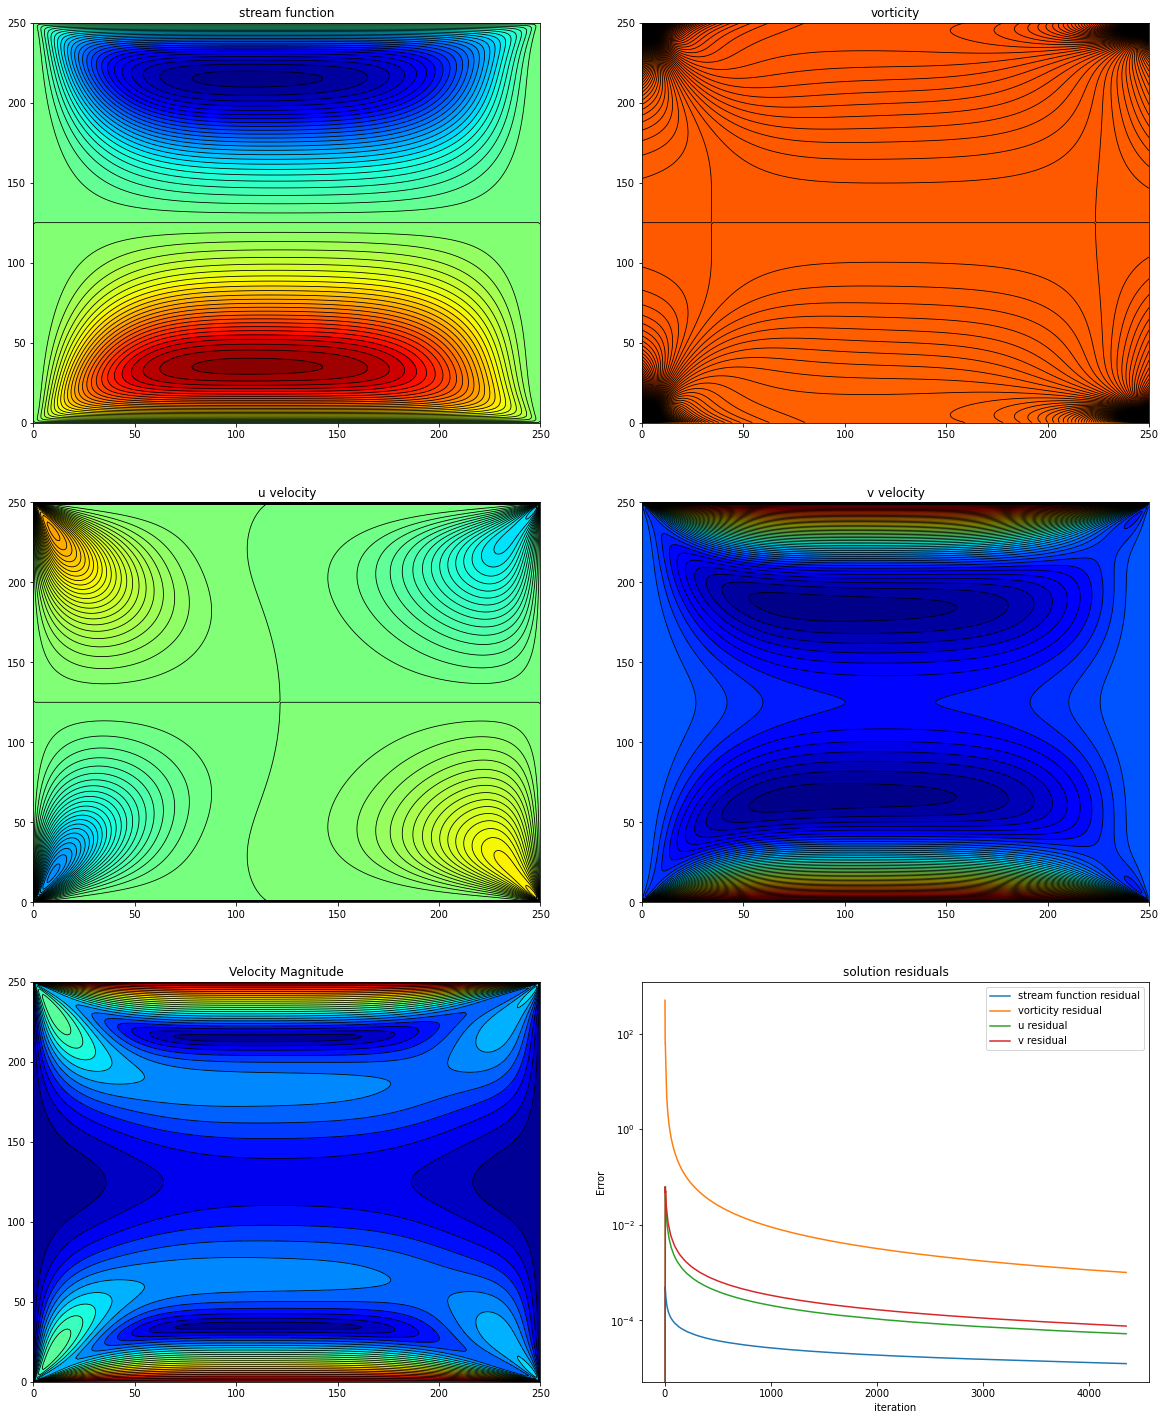

In [ ]:

plt.rcParams['contour.negative_linestyle'] = 'solid'

fig, ax = plt.subplots(3,2,figsize=(20,25))

ax[0,0].contour(sf_imgs[-1],50,colors='k',linewidths=0.8)
ax[0,0].contourf(sf_imgs[-1],50,cmap='jet')
ax[0,0].set_title("stream function")

ax[0,1].contour(w_imgs[-1],1000,colors='k',linewidths=0.8)
ax[0,1].contourf(w_imgs[-1],1000,cmap='hot')
ax[0,1].set_title("vorticity")

ax[1,0].contour(u_imgs[-1],100,colors='k',linewidths=0.8)
ax[1,0].contourf(u_imgs[-1],100,cmap='jet')
ax[1,0].set_title("u velocity")

ax[1,1].contour(v_imgs[-1],50,colors='k',linewidths=0.8)
ax[1,1].contourf(v_imgs[-1],50,cmap='jet')
ax[1,1].set_title("v velocity")

ax[2,0].contour(V_total[-1],30,colors='k',linewidths=0.8)
ax[2,0].contourf(V_total[-1],30,cmap='jet')
ax[2,0].set_title("Velocity Magnitude")

ax[2,1].set_yscale('log')
ax[2,1].plot(sf_residuals,label='stream function residual')
ax[2,1].plot(w_residuals, label='vorticity residual')
ax[2,1].plot(u_residuals, label='u residual')
ax[2,1].plot(v_residuals, label='v residual')
ax[2,1].legend()
ax[2,1].set_xlabel('iteration')
ax[2,1].set_ylabel('Error')
ax[2,1].set_title("solution residuals")